# Cooking with Leftovers Part 2: Deep Learning

In [2]:
# Import necessary packages for exploratory data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import boto3

# Table of Contents - Neural Network Models

1. [Model 1.0](#1) <br>
    1.1 [Model 1.1](#1.1) <br>
2. [Model 2.0](#2.0) <br>
    2.1 [Model 2.1](#2.1) <br>
    2.2 [Model 2.2](#2.2) <br>
    2.3 [Model 2.3](#2.3) <br>
3. [Model 3.0](#3.0) <br>
    3.1 [Model 3.1](#3.1) <br>
    3.2 [Model 3.2](#3.2) <br>
    3.3 [Model 3.3](#3.3) <br>
    3.4 [Model 3.4](#3.4) <br>
    3.5 [Model 3.5](#3.5) <br>
    3.6 [Model 3.6](#3.6) <br>
    3.7 [Model 3.7](#3.7) <br>
    

This notebook is a continuation of the **Cooking with Leftovers** notebook. This notebook will contain the neural networks and each optimized version. As I have saved the cleaned and preprocessed dataframe onto my s3 bucket in the first notebook, I will instantiate a s3 client and read in the cleaned data `cuisines_df`.

In [3]:
# Instantiate s3 client
s3 = boto3.client('s3')

# Send request to list buckets and assign to a variable
response = s3.list_buckets()

# Grab specific files from specified bucket
obj = s3.get_object(Bucket = 'sam-bstncapstone-bucket',Key = 'cuisines_df.csv')

# Read csv into dataframe
cuisines_df = pd.read_csv(obj['Body'])

In [14]:
# Drop un-needed index
cuisines_df.drop(columns = 'Unnamed: 0', inplace = True)

In [19]:
# View Data
cuisines_df.head()

,cuisine,achiote,fat-free sweetened condensed milk,flat rice noodles,yukon gold potatoes,marmite,fresh lima beans,chicken stock cube,spinach salad dressing,old english cheese,...,el torito adobo al pastor sauce,raw small shrimp,artificial flower,celery salt,desiccated coconut,skinless turkey thighs,german chocolate cake mix,vegan taco seasoning,hawaiian roll,allspice berries
0,mexican,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,american,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,american,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,american,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,american,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Check shape
print(f' There are {cuisines_df.shape[0]} rows, and {cuisines_df.shape[1]} columns')

 There are 54419 rows, and 9865 columns


In [20]:
#Check dtypes
cuisines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54419 entries, 0 to 54418
Columns: 9865 entries, cuisine to allspice berries
dtypes: int64(9864), object(1)
memory usage: 4.0+ GB


Everthing looks good, the data types for my columns seem to have reverted back to `int64` when I saved my data to a .csv file, so we will convert it to `int8` to save memory.

In [21]:
# Reduce Dtype of int64 -> int8
cuisines_df = cuisines_df.astype({col: 'int8' for col in cuisines_df.select_dtypes('int64').columns})

In [23]:
# Sanity check
cuisines_df.head()

,cuisine,achiote,fat-free sweetened condensed milk,flat rice noodles,yukon gold potatoes,marmite,fresh lima beans,chicken stock cube,spinach salad dressing,old english cheese,...,el torito adobo al pastor sauce,raw small shrimp,artificial flower,celery salt,desiccated coconut,skinless turkey thighs,german chocolate cake mix,vegan taco seasoning,hawaiian roll,allspice berries
0,mexican,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,american,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,american,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,american,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,american,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that we have our imported data, let's continue with our deep learning neural network.

# Neural Network
<a id='NN'></a>

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Before continuing, I will need to adjust my target cuisine column. As neural networks require my target column to be numeric, I will remap the cuisines as follows:

- american: 0
- european: 1
- asian: 2
-mexican: 3

In [29]:
# Remap cuisines column for neural network
cuisines_df['cuisine'] = cuisines_df['cuisine'].map({'american':0,'european':1,'asian':2,'mexican':3})

In [30]:
# Sanity check
cuisines_df

,cuisine,achiote,fat-free sweetened condensed milk,flat rice noodles,yukon gold potatoes,marmite,fresh lima beans,chicken stock cube,spinach salad dressing,old english cheese,...,el torito adobo al pastor sauce,raw small shrimp,artificial flower,celery salt,desiccated coconut,skinless turkey thighs,german chocolate cake mix,vegan taco seasoning,hawaiian roll,allspice berries
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54414,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54415,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54416,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54417,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This looks good, let's continue with setting our train, test, and validation data.

In [31]:
X = cuisines_df.drop(columns = 'cuisine')
y = cuisines_df['cuisine']
X_remainder,X_test,y_remainder,y_test = train_test_split(X,y,test_size = 0.2, random_state = 1)

In [32]:
X_train,X_validation,y_train,y_validation = train_test_split(X_remainder,y_remainder, test_size = 0.2, random_state = 3)

Listed below are the test accuracies and losses in each model. This table is provided at the end of the notebook as well, however I have listed it here in case you are interested in just the model results.

**Model Assessment with Neural Networks** <br>
    
| Model   | Test Accuracy   | Test Loss |
|-------------|-------|-------|
| [Model 1.0](#1) | 0.6972 | 7.0434 |
| [Model 1.1](#1.1) | 0.7025 | 2.8806 |
| [Model 2.0](#2.0) | 0.7067 | 4.3566 |
| [Model 2.1](#2.1) | 0.7139 | 2.7307 |
| [Model 2.2](#2.2) | 0.7229 | 2.3376 |
| [Model 2.3](#2.3) | 0.7326 | 1.6859 |
| [Model 3.0](#3.0) | 0.7178 | 3.7912 |
| [Model 3.1](#3.1) | 0.7159 | 3.2407 |
| [Model 3.2](#3.2) | 0.7215 | 2.4860 |
| [Model 3.3](#3.3) | 0.7303 | 2.1344 |
| [Model 3.4](#3.4) | 0.7219 | 3.2631 |
| [Model 3.5](#3.5) | 0.7381 | 1.6143 |
| [Model 3.6](#3.6) | 0.7359 | 1.5543 |
| [Model 3.7](#3.7) | 0.7335 | 1.9077 |


# Model 1.0
<a id='1'></a>

In [55]:
# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(50, activation="relu")) 

# Declare the output layer
model.add(layers.Dense(4, activation="softmax"))

First, let's try 5 hidden layers, alternating between 50 and 100 neurons. The activation we used is `relu` which is the default, and most commonly used. For our output layer, I've set it to 4 as we have 4 different cuisines we are trying to predict. The activation for the output layer is `softmax`, which gives the probability distribution of each class. This distribution will be between 0 and 1, and the class with the highest probability will be used as the predicted cuisine.

In [56]:
# Set optimizer, loss, and metrics for our neural network
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

Since we have set our target column with values from 0-3 depending on the cuisine, we have to use `SparseCategoricalCrossentropy()` for our loss function, and `SpareCategoricalAccuracy()` for our metrics. If we had one hot encoded our cuisine columns, we would then have to use `CategoricalCrossEntropy()` for loss, and `CategoricalAccuracy()` for our metrics. While they are both very similar, the difference in which method you use lies in the way you set your target column.

In [57]:
# Fit model on our train data
history = model.fit(X_remainder,y_remainder, validation_data = (X_validation,y_validation), epochs=100, verbose=1)

Epoch 1/100
1361/1361 [==============================] - 5s 3ms/step - loss: 0.6885 - sparse_categorical_accuracy: 0.7148 - val_loss: 0.5031 - val_sparse_categorical_accuracy: 0.7999
Epoch 2/100
1361/1361 [==============================] - 4s 3ms/step - loss: 0.5176 - sparse_categorical_accuracy: 0.7893 - val_loss: 0.4178 - val_sparse_categorical_accuracy: 0.8409
Epoch 3/100
1361/1361 [==============================] - 4s 3ms/step - loss: 0.4178 - sparse_categorical_accuracy: 0.8319 - val_loss: 0.3062 - val_sparse_categorical_accuracy: 0.8823
Epoch 4/100
1361/1361 [==============================] - 4s 3ms/step - loss: 0.3199 - sparse_categorical_accuracy: 0.8727 - val_loss: 0.2199 - val_sparse_categorical_accuracy: 0.9220
Epoch 5/100
1361/1361 [==============================] - 4s 3ms/step - loss: 0.2332 - sparse_categorical_accuracy: 0.9080 - val_loss: 0.1619 - val_sparse_categorical_accuracy: 0.9397
Epoch 6/100
1361/1361 [==============================] - 4s 3ms/step - loss: 0.1718 -

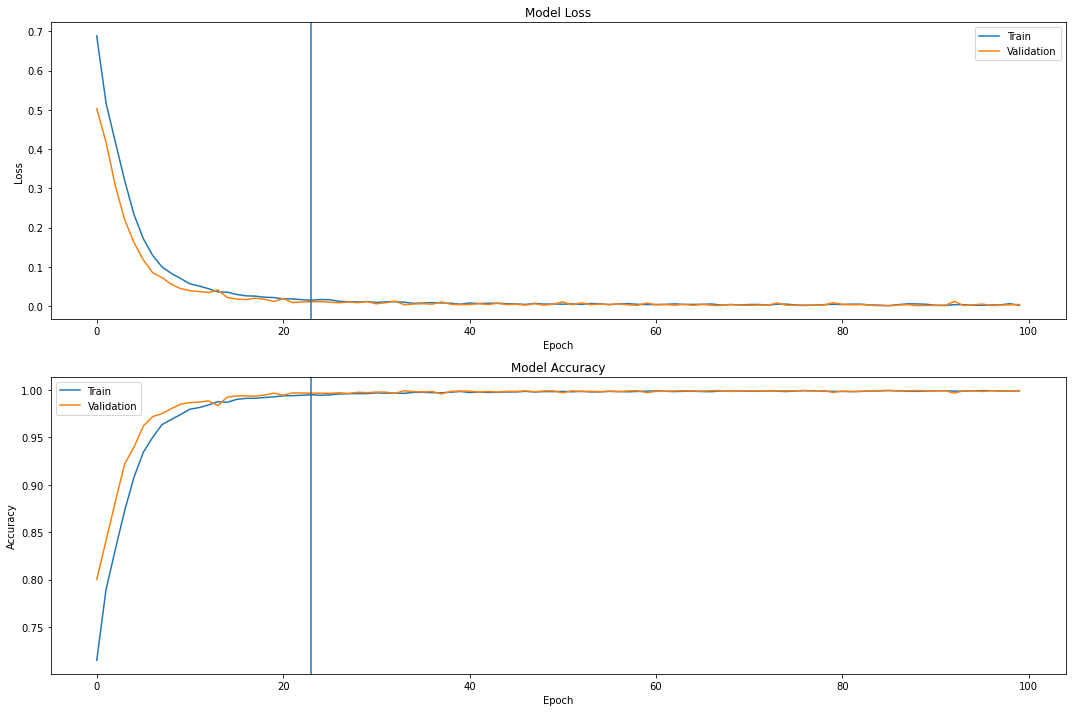

In [58]:
# Plot loss and accuracy
plt.subplots(2,1, figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.axvline(x = 23)
plt.legend(['Train', 'Validation'])

plt.subplot(2,1,2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.axvline(x = 23)

plt.tight_layout()
plt.show()

By observing the skree plots above, we can see that after training for 100 epochs, it seems that we are able to minimize the loss as early as roughly 25 epochs. There is also very little to no overfitting in our accuracy. Since this is the case, we can reduce the number of epochs for our next models. For now, let's check our accuracies of this unoptimized model.

In [59]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
print(f'Test Loss: {result[0]:.4f}')

predictions = model.predict(X_test)

Train Accuracy: 0.9991
Test Accuracy: 0.6972
Test Loss: 7.0434


Using 5 hidden layers, with 50/100 neurons in each layer, we were able to achieve a 69.38% test accuracy, and 99.82% train accuracy. While our model does really well in fitting to our train data, as well as predicting the validation set, it seems to have a hard time predicting the recipes in the test set.

# Model 1.1 with less Epochs (23)
<a id='1.1'></a>

In [60]:
# Create a new sequential model
model1 = keras.Sequential()

# Declare the hidden layers
model1.add(layers.Dense(50, activation="relu"))
model1.add(layers.Dense(100, activation="relu"))
model1.add(layers.Dense(50, activation="relu"))
model1.add(layers.Dense(100, activation="relu"))
model1.add(layers.Dense(50, activation="relu")) 

# Declare the output layer
model1.add(layers.Dense(4, activation="softmax"))

In [61]:
# Set optimizer, loss, and metrics for our neural network
model1.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [62]:
# Fit model on our train data
history = model1.fit(X_remainder,y_remainder, validation_data = (X_validation,y_validation), epochs=23, verbose=1)

Epoch 1/23
1361/1361 [==============================] - 5s 3ms/step - loss: 0.6835 - sparse_categorical_accuracy: 0.7137 - val_loss: 0.5004 - val_sparse_categorical_accuracy: 0.8048
Epoch 2/23
1361/1361 [==============================] - 4s 3ms/step - loss: 0.5159 - sparse_categorical_accuracy: 0.7910 - val_loss: 0.4140 - val_sparse_categorical_accuracy: 0.8366
Epoch 3/23
1361/1361 [==============================] - 4s 3ms/step - loss: 0.4179 - sparse_categorical_accuracy: 0.8311 - val_loss: 0.3279 - val_sparse_categorical_accuracy: 0.8706
Epoch 4/23
1361/1361 [==============================] - 4s 3ms/step - loss: 0.3207 - sparse_categorical_accuracy: 0.8716 - val_loss: 0.2257 - val_sparse_categorical_accuracy: 0.9156
Epoch 5/23
1361/1361 [==============================] - 4s 3ms/step - loss: 0.2396 - sparse_categorical_accuracy: 0.9055 - val_loss: 0.1525 - val_sparse_categorical_accuracy: 0.9460
Epoch 6/23
1361/1361 [==============================] - 4s 3ms/step - loss: 0.1718 - spars

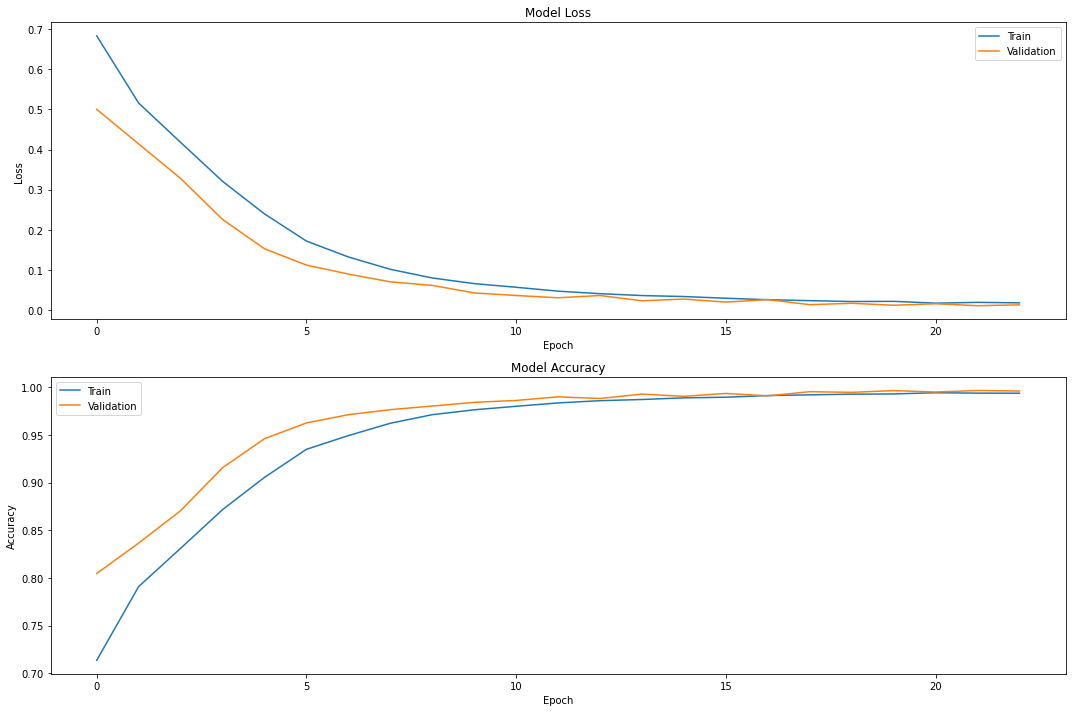

In [63]:
# Plot loss and accuracy
plt.subplots(2,1, figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(2,1,2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [64]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model1.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
print(f'Test Loss: {result[0]:.4f}')

predictions = model1.predict(X_test)

Train Accuracy: 0.9937
Test Accuracy: 0.7025
Test Loss: 2.8806


Again, the skree plots look great. The loss of both the train and validation set closely followed the same direction, and the accuracies indicated very minimal overfitting. Upon evaluating our model on the test data, it seems we were able to slightly improve our test accuracy by approximately 1%. Let's see if we can improve that by changing the number of neurons in each hidden layer.

# Model 2.0
<a id='2.0'></a>

In [65]:
# Create a new sequential model
model2 = keras.Sequential()

# Declare the hidden layers
model2.add(layers.Dense(100, activation="relu"))
model2.add(layers.Dense(200, activation="relu"))
model2.add(layers.Dense(100, activation="relu"))
model2.add(layers.Dense(200, activation="relu"))
model2.add(layers.Dense(100, activation="relu")) 

# Declare the output layer
model2.add(layers.Dense(4, activation="softmax"))

Let's try the same number of hidden layers, however let's increase our number of neurons to 100/200/100/200/100.

In [66]:
# Set optimizer, loss, and metrics for our neural network
model2.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [67]:
# Fit model on our train data
history = model2.fit(X_remainder,y_remainder, validation_data = (X_validation,y_validation), epochs=50, verbose=1)

Epoch 1/50
1361/1361 [==============================] - 6s 4ms/step - loss: 0.6840 - sparse_categorical_accuracy: 0.7186 - val_loss: 0.5045 - val_sparse_categorical_accuracy: 0.8044
Epoch 2/50
1361/1361 [==============================] - 6s 4ms/step - loss: 0.5043 - sparse_categorical_accuracy: 0.7964 - val_loss: 0.3747 - val_sparse_categorical_accuracy: 0.8585
Epoch 3/50
1361/1361 [==============================] - 6s 4ms/step - loss: 0.3780 - sparse_categorical_accuracy: 0.8481 - val_loss: 0.2426 - val_sparse_categorical_accuracy: 0.9141
Epoch 4/50
1361/1361 [==============================] - 6s 4ms/step - loss: 0.2442 - sparse_categorical_accuracy: 0.9035 - val_loss: 0.1470 - val_sparse_categorical_accuracy: 0.9503
Epoch 5/50
1361/1361 [==============================] - 6s 4ms/step - loss: 0.1513 - sparse_categorical_accuracy: 0.9412 - val_loss: 0.0871 - val_sparse_categorical_accuracy: 0.9714
Epoch 6/50
1361/1361 [==============================] - 5s 4ms/step - loss: 0.0959 - spars

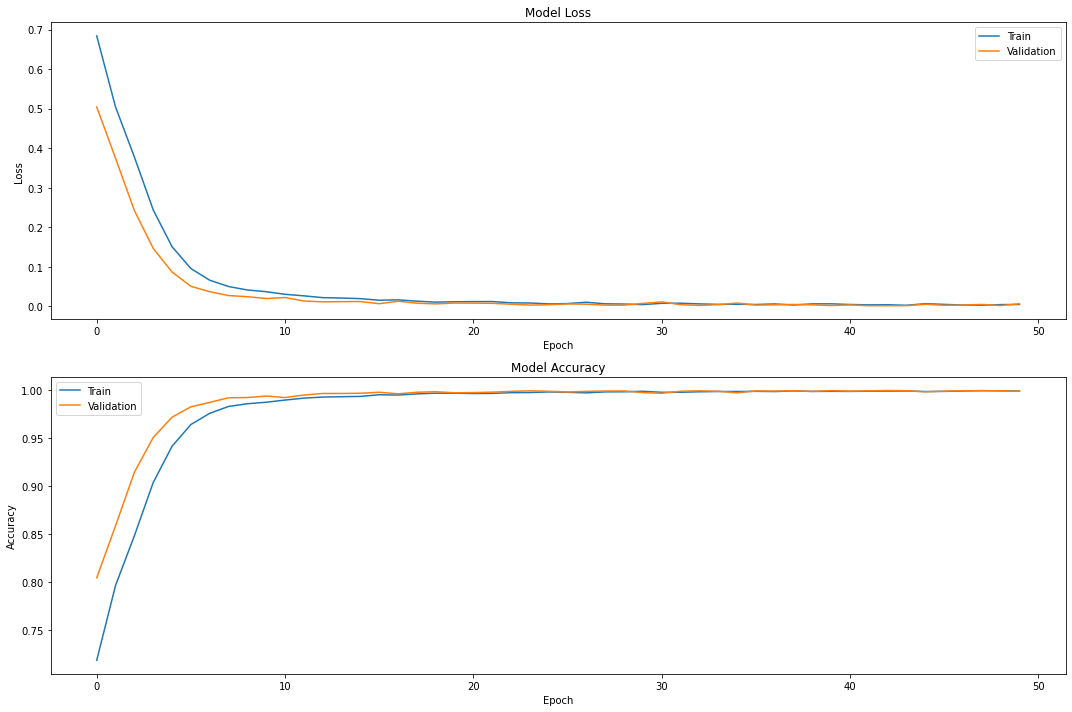

In [68]:
# Plot loss and accuracy
plt.subplots(2,1, figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(2,1,2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [69]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model2.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
print(f'Test Loss: {result[0]:.4f}')

predictions = model2.predict(X_test)

Train Accuracy: 0.9986
Test Accuracy: 0.7067
Test Loss: 4.3566


It seems that increasing the number of neurons per layer increased our test accuracy. Compared to our model with 23 epochs, we were able to increase our accuracies again by just over 1%. It seems that we can also reduce our number of epochs to approximately 15, so we will try again with less epochs.

# Model 2.1 with 15 epoch
<a id='2.1'></a>

In [70]:
# Create a new sequential model
model3 = keras.Sequential()

# Declare the hidden layers
model3.add(layers.Dense(100, activation="relu"))
model3.add(layers.Dense(200, activation="relu"))
model3.add(layers.Dense(100, activation="relu"))
model3.add(layers.Dense(200, activation="relu"))
model3.add(layers.Dense(100, activation="relu")) 

# Declare the output layer
model3.add(layers.Dense(4, activation="softmax"))

In [71]:
# Set optimizer, loss, and metrics for our neural network
model3.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [72]:
# Fit model on our train data
history = model3.fit(X_remainder,y_remainder, validation_data = (X_validation,y_validation), epochs=15, verbose=1)

Epoch 1/15
1361/1361 [==============================] - 6s 5ms/step - loss: 0.6868 - sparse_categorical_accuracy: 0.7163 - val_loss: 0.5150 - val_sparse_categorical_accuracy: 0.7998
Epoch 2/15
1361/1361 [==============================] - 6s 4ms/step - loss: 0.5038 - sparse_categorical_accuracy: 0.7960 - val_loss: 0.3919 - val_sparse_categorical_accuracy: 0.8593
Epoch 3/15
1361/1361 [==============================] - 6s 4ms/step - loss: 0.3731 - sparse_categorical_accuracy: 0.8524 - val_loss: 0.2342 - val_sparse_categorical_accuracy: 0.9188
Epoch 4/15
1361/1361 [==============================] - 6s 4ms/step - loss: 0.2436 - sparse_categorical_accuracy: 0.9047 - val_loss: 0.1399 - val_sparse_categorical_accuracy: 0.9482
Epoch 5/15
1361/1361 [==============================] - 6s 4ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.0768 - val_sparse_categorical_accuracy: 0.9777
Epoch 6/15
1361/1361 [==============================] - 6s 4ms/step - loss: 0.0933 - spars

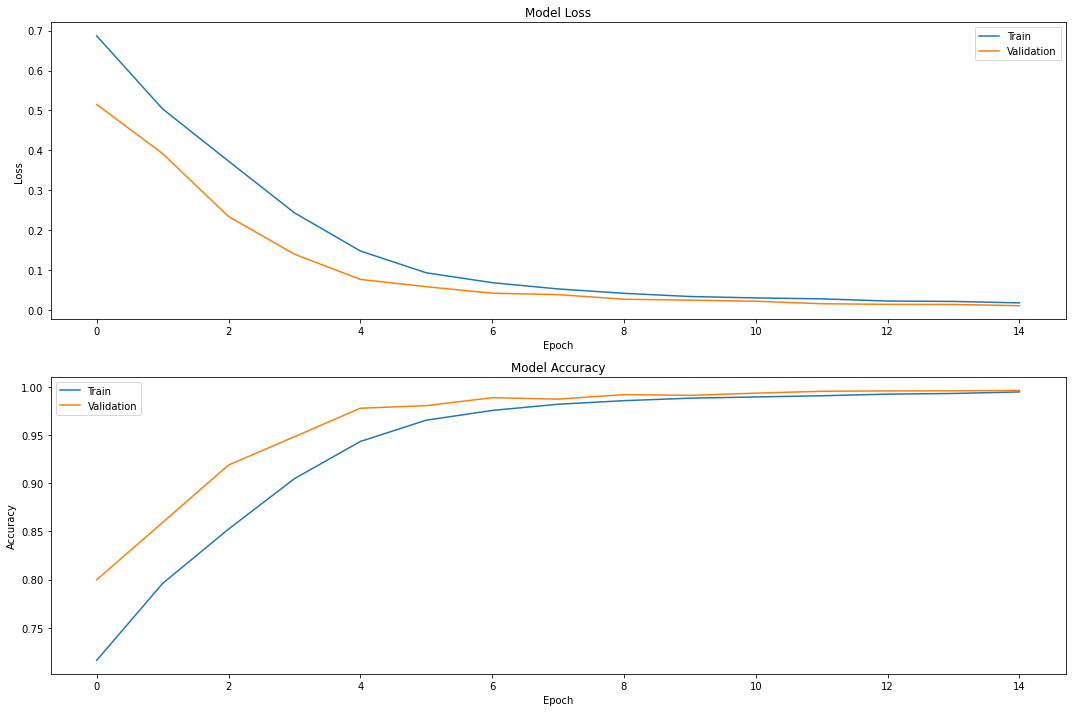

In [73]:
# Plot loss and accuracy
plt.subplots(2,1, figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(2,1,2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [74]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model3.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
print(f'Test Loss: {result[0]:.4f}')

predictions = model3.predict(X_test)

Train Accuracy: 0.9946
Test Accuracy: 0.7139
Test Loss: 2.7307


This model seemed to have a slightly lower test accuracy (<0.5%) than our previous model with 50 epochs, however due to the random nature of our neural network, it is possible that if we were to run multiple instances of each model and then average the test score of each models, they could have very similar test accuracies. Let's try adding dropout layers to our model.

# Model 2.2 with dropout
<a id='2.2'></a>

In [75]:
# Create a new sequential model
model4 = keras.Sequential()

# Declare the hidden layers
model4.add(layers.Dense(100, activation="relu"))
model4.add(Dropout(0.25))
model4.add(layers.Dense(200, activation="relu"))
model4.add(Dropout(0.25))
model4.add(layers.Dense(100, activation="relu"))
model4.add(Dropout(0.25))
model4.add(layers.Dense(200, activation="relu"))
model4.add(Dropout(0.25))
model4.add(layers.Dense(100, activation="relu"))
model4.add(Dropout(0.25))

# Declare the output layer
model4.add(layers.Dense(4, activation="softmax"))

In [76]:
# Set optimizer, loss, and metrics for our neural network
model4.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [77]:
# Fit model on our train data
history = model4.fit(X_remainder,y_remainder, validation_data = (X_validation,y_validation), epochs=30, verbose=1)

Epoch 1/30
1361/1361 [==============================] - 7s 5ms/step - loss: 0.7451 - sparse_categorical_accuracy: 0.6913 - val_loss: 0.5201 - val_sparse_categorical_accuracy: 0.8029
Epoch 2/30
1361/1361 [==============================] - 6s 4ms/step - loss: 0.5627 - sparse_categorical_accuracy: 0.7779 - val_loss: 0.4270 - val_sparse_categorical_accuracy: 0.8408
Epoch 3/30
1361/1361 [==============================] - 6s 5ms/step - loss: 0.4737 - sparse_categorical_accuracy: 0.8173 - val_loss: 0.3305 - val_sparse_categorical_accuracy: 0.8784
Epoch 4/30
1361/1361 [==============================] - 6s 5ms/step - loss: 0.3930 - sparse_categorical_accuracy: 0.8491 - val_loss: 0.2525 - val_sparse_categorical_accuracy: 0.9087
Epoch 5/30
1361/1361 [==============================] - 6s 5ms/step - loss: 0.3238 - sparse_categorical_accuracy: 0.8795 - val_loss: 0.1833 - val_sparse_categorical_accuracy: 0.9361
Epoch 6/30
1361/1361 [==============================] - 6s 5ms/step - loss: 0.2672 - spars

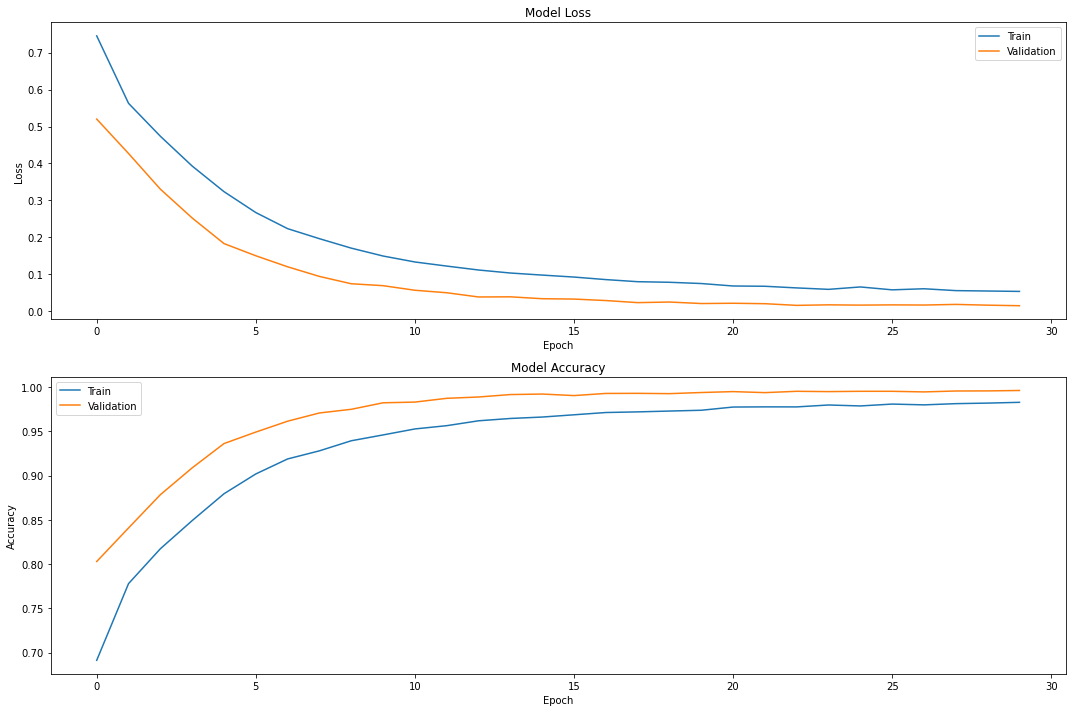

In [78]:
# Plot loss and accuracy
plt.subplots(2,1, figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(2,1,2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [79]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model4.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
print(f'Test Loss: {result[0]:.4f}')

predictions = model4.predict(X_test)

Train Accuracy: 0.9827
Test Accuracy: 0.7229
Test Loss: 2.3376


Adding dropout layers with a 25% dropout rate after each hidden layer seemed to increase our test accuracy slightly, to 72.51%. I will try again, with a higher dropout rate to see if this increases our test scores.

# Model 2.3
<a id='2.3'></a>

In [80]:
# Create a new sequential model
model5 = keras.Sequential()

# Declare the hidden layers
model5.add(layers.Dense(100, activation="relu"))
model5.add(Dropout(0.35))
model5.add(layers.Dense(200, activation="relu"))
model5.add(Dropout(0.35))
model5.add(layers.Dense(100, activation="relu"))
model5.add(Dropout(0.35))
model5.add(layers.Dense(200, activation="relu"))
model5.add(Dropout(0.35))
model5.add(layers.Dense(100, activation="relu"))
model5.add(Dropout(0.35))

# Declare the output layer
model5.add(layers.Dense(4, activation="softmax"))

In [81]:
# Set optimizer, loss, and metrics for our neural network
model5.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [82]:
# Fit model on our train data
history = model5.fit(X_remainder,y_remainder, validation_data = (X_validation,y_validation), epochs=30, verbose=1)

Epoch 1/30
1361/1361 [==============================] - 7s 5ms/step - loss: 0.7858 - sparse_categorical_accuracy: 0.6784 - val_loss: 0.5503 - val_sparse_categorical_accuracy: 0.7868
Epoch 2/30
1361/1361 [==============================] - 6s 5ms/step - loss: 0.6037 - sparse_categorical_accuracy: 0.7637 - val_loss: 0.4626 - val_sparse_categorical_accuracy: 0.8206
Epoch 3/30
1361/1361 [==============================] - 6s 5ms/step - loss: 0.5231 - sparse_categorical_accuracy: 0.7964 - val_loss: 0.3901 - val_sparse_categorical_accuracy: 0.8499
Epoch 4/30
1361/1361 [==============================] - 6s 5ms/step - loss: 0.4593 - sparse_categorical_accuracy: 0.8223 - val_loss: 0.3294 - val_sparse_categorical_accuracy: 0.8786
Epoch 5/30
1361/1361 [==============================] - 6s 5ms/step - loss: 0.4035 - sparse_categorical_accuracy: 0.8490 - val_loss: 0.2669 - val_sparse_categorical_accuracy: 0.9088
Epoch 6/30
1361/1361 [==============================] - 6s 5ms/step - loss: 0.3561 - spars

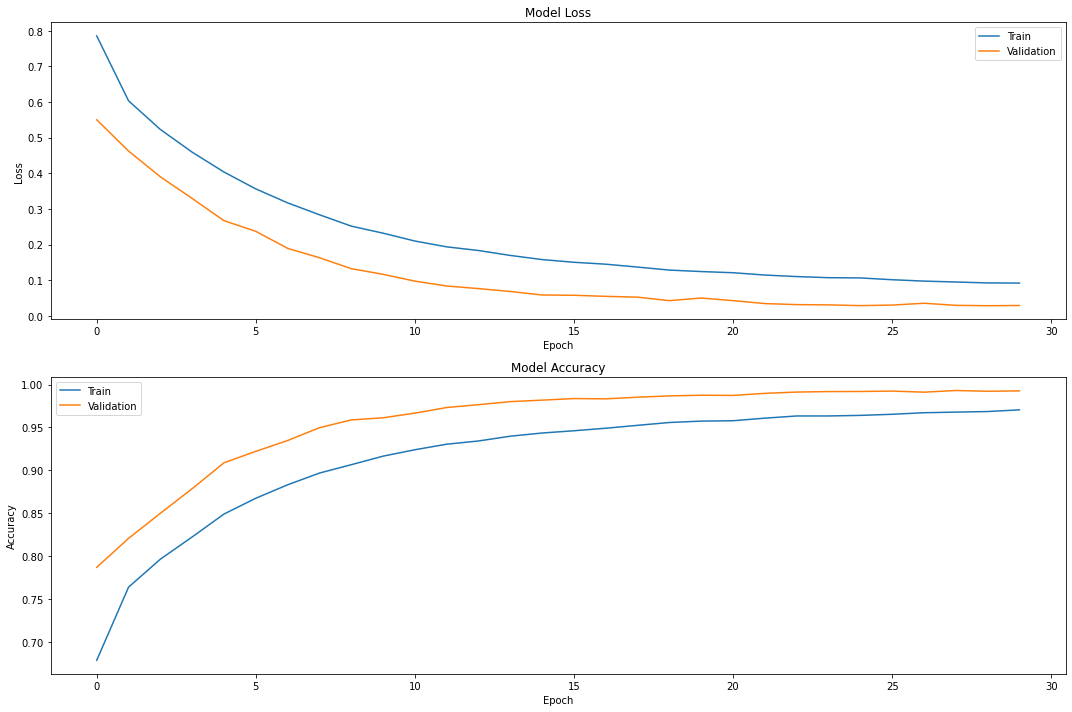

In [83]:
# Plot loss and accuracy
plt.subplots(2,1, figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(2,1,2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [84]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model5.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
print(f'Test Loss: {result[0]:.4f}')

predictions = model5.predict(X_test)

Train Accuracy: 0.9705
Test Accuracy: 0.7326
Test Loss: 1.6859


Increasing the dropout rate did not seem to increase our accuracies. It did however, slightly reduce our overfitting on the train data. Perhaps we can try increasing the number of hidden layers, as well as the number of neurons in each layer.

# Model 3.0
<a id='3.0'></a>

In [85]:
# Create a new sequential model
model6 = keras.Sequential()

# Declare the hidden layers
model6.add(layers.Dense(250, activation="relu"))
model6.add(layers.Dense(500, activation="relu"))
model6.add(layers.Dense(250, activation="relu"))
model6.add(layers.Dense(500, activation="relu"))
model6.add(layers.Dense(250, activation="relu")) 
model6.add(layers.Dense(500, activation="relu"))
model6.add(layers.Dense(250, activation="relu")) 

# Declare the output layer
model6.add(layers.Dense(4, activation="softmax"))

Let's try 7 hidden layers, with 250/500 neurons alternating in each layer.

In [86]:
# Set optimizer, loss, and metrics for our neural network
model6.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [87]:
# Fit model on our train data
history = model6.fit(X_remainder,y_remainder, validation_data = (X_validation,y_validation), epochs=50, verbose=1)

Epoch 1/50
1361/1361 [==============================] - 13s 9ms/step - loss: 0.7215 - sparse_categorical_accuracy: 0.7055 - val_loss: 0.5157 - val_sparse_categorical_accuracy: 0.8011
Epoch 2/50
1361/1361 [==============================] - 13s 9ms/step - loss: 0.5200 - sparse_categorical_accuracy: 0.7953 - val_loss: 0.3821 - val_sparse_categorical_accuracy: 0.8664
Epoch 3/50
1361/1361 [==============================] - 12s 9ms/step - loss: 0.3628 - sparse_categorical_accuracy: 0.8622 - val_loss: 0.2228 - val_sparse_categorical_accuracy: 0.9299
Epoch 4/50
1361/1361 [==============================] - 12s 9ms/step - loss: 0.2065 - sparse_categorical_accuracy: 0.9244 - val_loss: 0.1014 - val_sparse_categorical_accuracy: 0.9680
Epoch 5/50
1361/1361 [==============================] - 12s 9ms/step - loss: 0.1114 - sparse_categorical_accuracy: 0.9597 - val_loss: 0.0643 - val_sparse_categorical_accuracy: 0.9761
Epoch 6/50
1361/1361 [==============================] - 12s 9ms/step - loss: 0.0698 -

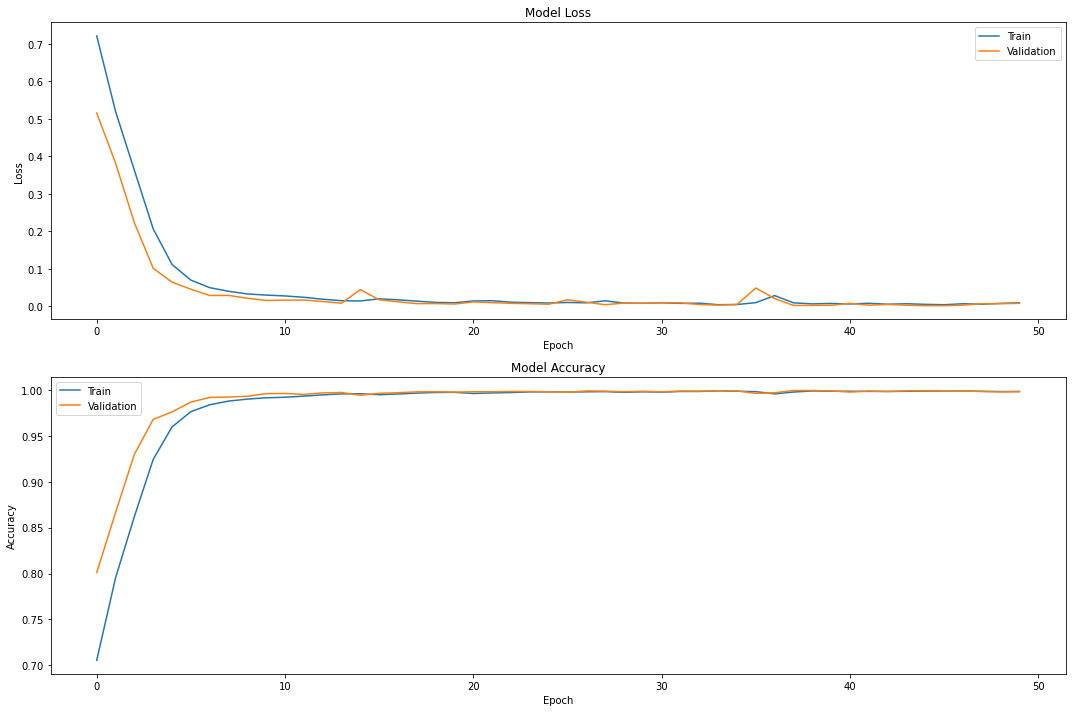

In [88]:
# Plot loss and accuracy
plt.subplots(2,1, figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(2,1,2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [89]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model6.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
print(f'Test Loss: {result[0]:.4f}')

predictions = model6.predict(X_test)

Train Accuracy: 0.9983
Test Accuracy: 0.7178
Test Loss: 3.7912


Overall, we observe a very similar test accuracy when comparing this neural network to our previous models. Upon looking at our scree plots, we minimize our loss and maximize our accuracy at approximately 15 epochs, so let's try again with epochs = 15.

# Model 3.1 with 15 epochs
<a id='3.1'></a>

In [90]:
# Create a new sequential model
model7 = keras.Sequential()

# Declare the hidden layers
model7.add(layers.Dense(250, activation="relu"))
model7.add(layers.Dense(500, activation="relu"))
model7.add(layers.Dense(250, activation="relu"))
model7.add(layers.Dense(500, activation="relu"))
model7.add(layers.Dense(250, activation="relu")) 
model7.add(layers.Dense(500, activation="relu"))
model7.add(layers.Dense(250, activation="relu")) 

# Declare the output layer
model7.add(layers.Dense(4, activation="softmax"))

In [91]:
# Set optimizer, loss, and metrics for our neural network
model7.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [92]:
# Fit model on our train data
history = model7.fit(X_remainder,y_remainder, validation_data = (X_validation,y_validation), epochs=15, verbose=1)

Epoch 1/15
1361/1361 [==============================] - 13s 10ms/step - loss: 0.7188 - sparse_categorical_accuracy: 0.7058 - val_loss: 0.5061 - val_sparse_categorical_accuracy: 0.8003
Epoch 2/15
1361/1361 [==============================] - 12s 9ms/step - loss: 0.5141 - sparse_categorical_accuracy: 0.7970 - val_loss: 0.3726 - val_sparse_categorical_accuracy: 0.8602
Epoch 3/15
1361/1361 [==============================] - 12s 9ms/step - loss: 0.3591 - sparse_categorical_accuracy: 0.8609 - val_loss: 0.2110 - val_sparse_categorical_accuracy: 0.9259
Epoch 4/15
1361/1361 [==============================] - 12s 9ms/step - loss: 0.2027 - sparse_categorical_accuracy: 0.9247 - val_loss: 0.1137 - val_sparse_categorical_accuracy: 0.9620
Epoch 5/15
1361/1361 [==============================] - 12s 9ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.9612 - val_loss: 0.0605 - val_sparse_categorical_accuracy: 0.9791
Epoch 6/15
1361/1361 [==============================] - 12s 9ms/step - loss: 0.0693 

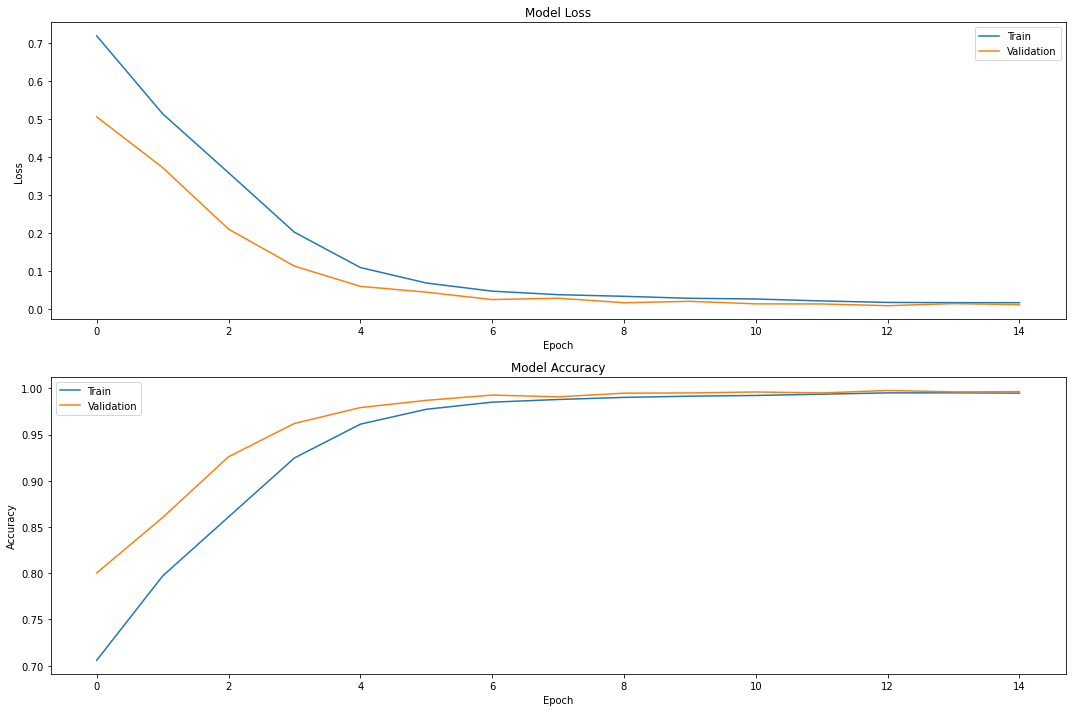

In [93]:
# Plot loss and accuracy
plt.subplots(2,1, figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(2,1,2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [94]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model7.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
print(f'Test Loss: {result[0]:.4f}')

predictions = model7.predict(X_test)

Train Accuracy: 0.9947
Test Accuracy: 0.7159
Test Loss: 3.2407


Decreasing the number of epochs to 15 resulted in a marginally higher test accuracy. Let's try again, but this time adding drop out layers between each layer, with a dropout rate of 0.25.

# Model 3.2 with dropout
<a id='3.2'></a>

In [95]:
# Create a new sequential model
model8 = keras.Sequential()

# Declare the hidden layers
model8.add(layers.Dense(250, activation="relu"))
model8.add(Dropout(0.25))
model8.add(layers.Dense(500, activation="relu"))
model8.add(Dropout(0.25))
model8.add(layers.Dense(250, activation="relu"))
model8.add(Dropout(0.25))
model8.add(layers.Dense(500, activation="relu"))
model8.add(Dropout(0.25))
model8.add(layers.Dense(250, activation="relu"))
model8.add(Dropout(0.25))
model8.add(layers.Dense(500, activation="relu"))
model8.add(Dropout(0.25))
model8.add(layers.Dense(250, activation="relu"))
model8.add(Dropout(0.25))

# Declare the output layer
model8.add(layers.Dense(4, activation="softmax"))

In [96]:
# Set optimizer, loss, and metrics for our neural network
model8.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [97]:
# Fit model on our train data
history = model8.fit(X_remainder,y_remainder, validation_data = (X_validation,y_validation), epochs=15, verbose=1)

Epoch 1/15
1361/1361 [==============================] - 15s 11ms/step - loss: 0.7681 - sparse_categorical_accuracy: 0.6869 - val_loss: 0.5426 - val_sparse_categorical_accuracy: 0.7917
Epoch 2/15
1361/1361 [==============================] - 14s 10ms/step - loss: 0.5765 - sparse_categorical_accuracy: 0.7786 - val_loss: 0.4236 - val_sparse_categorical_accuracy: 0.8414
Epoch 3/15
1361/1361 [==============================] - 14s 10ms/step - loss: 0.4683 - sparse_categorical_accuracy: 0.8207 - val_loss: 0.3338 - val_sparse_categorical_accuracy: 0.8837
Epoch 4/15
1361/1361 [==============================] - 14s 10ms/step - loss: 0.3595 - sparse_categorical_accuracy: 0.8659 - val_loss: 0.2200 - val_sparse_categorical_accuracy: 0.9227
Epoch 5/15
1361/1361 [==============================] - 14s 10ms/step - loss: 0.2744 - sparse_categorical_accuracy: 0.9007 - val_loss: 0.1426 - val_sparse_categorical_accuracy: 0.9523
Epoch 6/15
1361/1361 [==============================] - 14s 10ms/step - loss: 0.

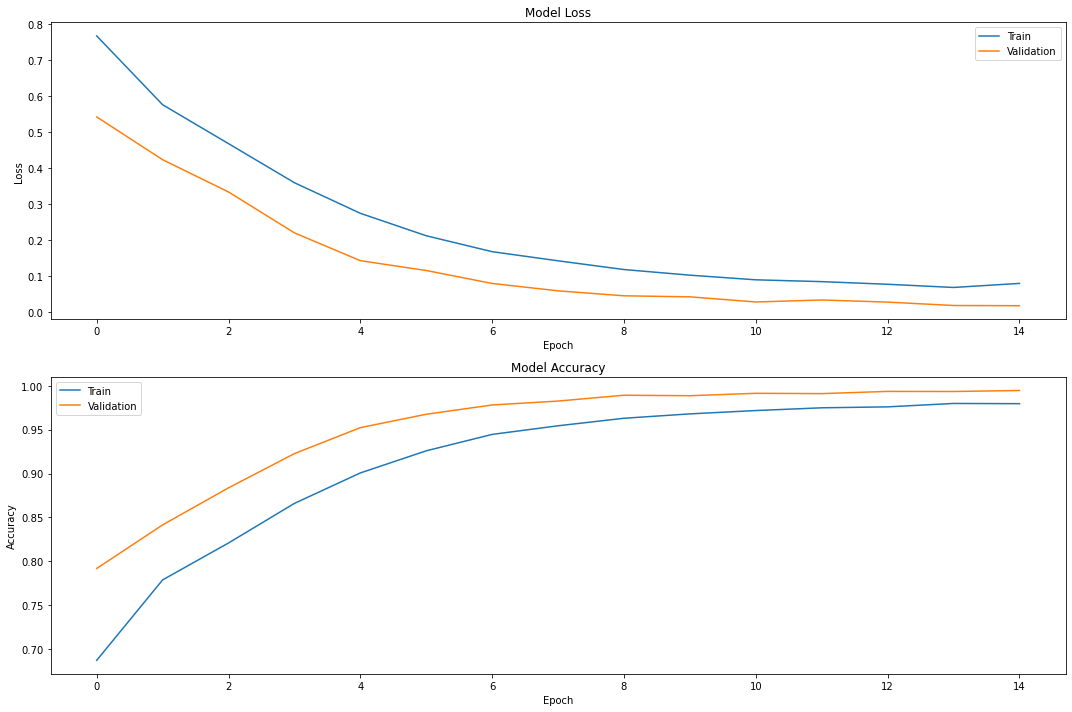

In [98]:
# Plot loss and accuracy
plt.subplots(2,1, figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(2,1,2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [99]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model8.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
print(f'Test Loss: {result[0]:.4f}')

predictions = model8.predict(X_test)

Train Accuracy: 0.9797
Test Accuracy: 0.7215
Test Loss: 2.4860


Again, even with dropout layers between each hidden layer, we notice very similar accuracies when compared to the previous model without dropout layers. Perhaps the dropout rate is not high enough, so we will try again, increasing the dropout rate to 0.3.

# Model 3.3 with higher dropout
<a id='3.3'></a>

In [100]:
# Create a new sequential model
model9 = keras.Sequential()

# Declare the hidden layers
model9.add(layers.Dense(250, activation="relu"))
model9.add(Dropout(0.3))
model9.add(layers.Dense(500, activation="relu"))
model9.add(Dropout(0.3))
model9.add(layers.Dense(250, activation="relu"))
model9.add(Dropout(0.3))
model9.add(layers.Dense(500, activation="relu"))
model9.add(Dropout(0.3))
model9.add(layers.Dense(250, activation="relu"))
model9.add(Dropout(0.3))
model9.add(layers.Dense(500, activation="relu"))
model9.add(Dropout(0.3))
model9.add(layers.Dense(250, activation="relu"))
model9.add(Dropout(0.3))

# Declare the output layer
model9.add(layers.Dense(4, activation="softmax"))

In [101]:
# Set optimizer, loss, and metrics for our neural network
model9.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [102]:
# Fit model on our train data
history = model9.fit(X_remainder,y_remainder, validation_data = (X_validation,y_validation), epochs=15, verbose=1)

Epoch 1/15
1361/1361 [==============================] - 16s 11ms/step - loss: 0.7832 - sparse_categorical_accuracy: 0.6785 - val_loss: 0.5643 - val_sparse_categorical_accuracy: 0.7557
Epoch 2/15
1361/1361 [==============================] - 14s 11ms/step - loss: 0.5871 - sparse_categorical_accuracy: 0.7725 - val_loss: 0.4426 - val_sparse_categorical_accuracy: 0.8345
Epoch 3/15
1361/1361 [==============================] - 14s 10ms/step - loss: 0.4880 - sparse_categorical_accuracy: 0.8159 - val_loss: 0.3267 - val_sparse_categorical_accuracy: 0.8781
Epoch 4/15
1361/1361 [==============================] - 14s 10ms/step - loss: 0.3914 - sparse_categorical_accuracy: 0.8541 - val_loss: 0.2520 - val_sparse_categorical_accuracy: 0.9151
Epoch 5/15
1361/1361 [==============================] - 14s 11ms/step - loss: 0.3102 - sparse_categorical_accuracy: 0.8865 - val_loss: 0.1832 - val_sparse_categorical_accuracy: 0.9376
Epoch 6/15
1361/1361 [==============================] - 15s 11ms/step - loss: 0.

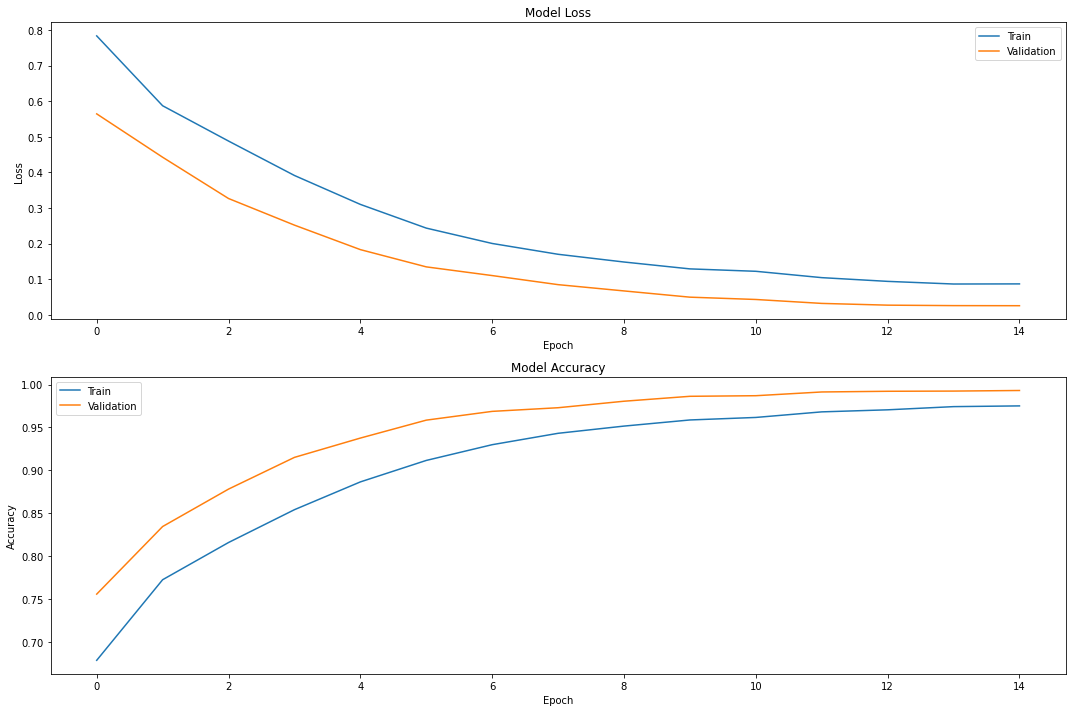

In [103]:
# Plot loss and accuracy
plt.subplots(2,1, figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(2,1,2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [104]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model9.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
print(f'Test Loss: {result[0]:.4f}')

predictions = model9.predict(X_test)

Train Accuracy: 0.9751
Test Accuracy: 0.7303
Test Loss: 2.1344


Increasing the dropout rate from 0.25 -> 0.3 resulted in a slight increase in our test accuracy. Let's try using only 3 drop out layers, but increasing the dropout rate to 0.4.

# Model 3.4
<a id='3.4'></a>

In [105]:
# Create a new sequential model
model10 = keras.Sequential()

# Declare the hidden layers
model10.add(layers.Dense(250, activation="relu"))
model10.add(layers.Dense(500, activation="relu"))
model10.add(Dropout(0.4))
model10.add(layers.Dense(250, activation="relu"))
model10.add(layers.Dense(500, activation="relu"))
model10.add(Dropout(0.4))
model10.add(layers.Dense(250, activation="relu"))
model10.add(layers.Dense(500, activation="relu"))
model10.add(Dropout(0.4))

# Declare the output layer
model10.add(layers.Dense(4, activation="softmax"))

In [106]:
# Set optimizer, loss, and metrics for our neural network
model10.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [107]:
# Fit model on our train data
history = model10.fit(X_remainder,y_remainder, validation_data = (X_validation,y_validation), epochs=15, verbose=1)

Epoch 1/15
1361/1361 [==============================] - 14s 10ms/step - loss: 0.7329 - sparse_categorical_accuracy: 0.7021 - val_loss: 0.5316 - val_sparse_categorical_accuracy: 0.8012
Epoch 2/15
1361/1361 [==============================] - 13s 9ms/step - loss: 0.5288 - sparse_categorical_accuracy: 0.7941 - val_loss: 0.3987 - val_sparse_categorical_accuracy: 0.8677
Epoch 3/15
1361/1361 [==============================] - 13s 9ms/step - loss: 0.3799 - sparse_categorical_accuracy: 0.8587 - val_loss: 0.2393 - val_sparse_categorical_accuracy: 0.9243
Epoch 4/15
1361/1361 [==============================] - 13s 9ms/step - loss: 0.2337 - sparse_categorical_accuracy: 0.9151 - val_loss: 0.1222 - val_sparse_categorical_accuracy: 0.9639
Epoch 5/15
1361/1361 [==============================] - 13s 10ms/step - loss: 0.1340 - sparse_categorical_accuracy: 0.9538 - val_loss: 0.0683 - val_sparse_categorical_accuracy: 0.9798
Epoch 6/15
1361/1361 [==============================] - 13s 10ms/step - loss: 0.085

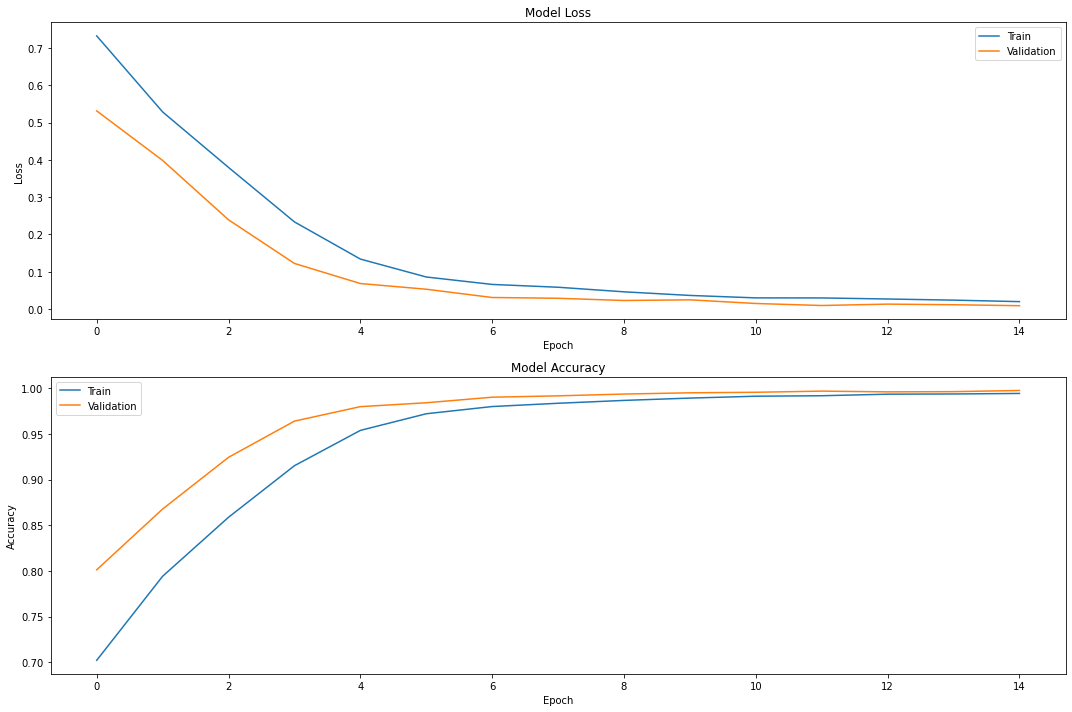

In [108]:
# Plot loss and accuracy
plt.subplots(2,1, figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(2,1,2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [109]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model10.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
print(f'Test Loss: {result[0]:.4f}')

predictions = model10.predict(X_test)

Train Accuracy: 0.9942
Test Accuracy: 0.7219
Test Loss: 3.2631


Using only 3 dropout layers, and ncreasing the dropout rate actually decreased our test accuracy slightly. Let's try keeping the same dropout rate (0.4), but placing the dropout layers at different hidden layers.

# Model 3.5 - Same as 3.4, but placing dropout layers at different locations
<a id='3.5'></a>

In [126]:
# Create a new sequential model
model11 = keras.Sequential()

# Declare the hidden layers
model11.add(layers.Dense(250, activation="relu"))
model11.add(Dropout(0.4))
model11.add(layers.Dense(500, activation="relu"))
model11.add(layers.Dense(250, activation="relu"))
model11.add(Dropout(0.4))
model11.add(layers.Dense(500, activation="relu"))
model11.add(layers.Dense(250, activation="relu"))
model11.add(Dropout(0.4))
model11.add(layers.Dense(500, activation="relu"))


# Declare the output layer
model11.add(layers.Dense(4, activation="softmax"))

In [127]:
# Set optimizer, loss, and metrics for our neural network
model11.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [128]:
# Fit model on our train data
history = model11.fit(X_remainder,y_remainder, validation_data = (X_validation,y_validation), epochs=15, verbose=1)

Epoch 1/15
1361/1361 [==============================] - 14s 10ms/step - loss: 0.7477 - sparse_categorical_accuracy: 0.6987 - val_loss: 0.5757 - val_sparse_categorical_accuracy: 0.8004
Epoch 2/15
1361/1361 [==============================] - 13s 9ms/step - loss: 0.5758 - sparse_categorical_accuracy: 0.7760 - val_loss: 0.4471 - val_sparse_categorical_accuracy: 0.8374
Epoch 3/15
1361/1361 [==============================] - 13s 9ms/step - loss: 0.4769 - sparse_categorical_accuracy: 0.8174 - val_loss: 0.3590 - val_sparse_categorical_accuracy: 0.8727
Epoch 4/15
1361/1361 [==============================] - 13s 9ms/step - loss: 0.3951 - sparse_categorical_accuracy: 0.8496 - val_loss: 0.2444 - val_sparse_categorical_accuracy: 0.9118
Epoch 5/15
1361/1361 [==============================] - 13s 9ms/step - loss: 0.3197 - sparse_categorical_accuracy: 0.8805 - val_loss: 0.1855 - val_sparse_categorical_accuracy: 0.9425
Epoch 6/15
1361/1361 [==============================] - 13s 9ms/step - loss: 0.2574 

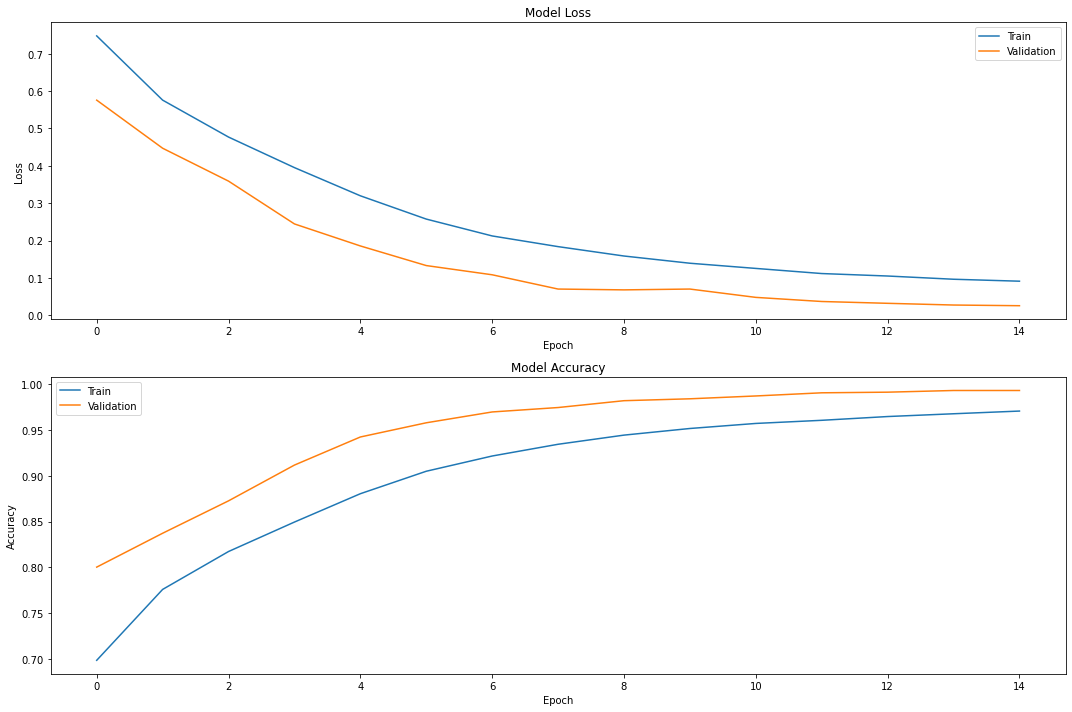

In [129]:
# Plot loss and accuracy
plt.subplots(2,1, figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(2,1,2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [130]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model11.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
print(f'Test Loss: {result[0]:.4f}')

predictions = model11.predict(X_test)

Train Accuracy: 0.9708
Test Accuracy: 0.7348
Test Loss: 1.8050


This model with 3 dropout layers had the best test accuracy out of the models tested. Let's use this and run a confusion matrix to see how accurately my model is classifying each cuisine.

# Model 3.6 - Dropout at every layer
<a id='3.6'></a>

In [115]:
# Create a new sequential model
model12 = keras.Sequential()

# Declare the hidden layers
model12.add(layers.Dense(250, activation="relu"))
model12.add(Dropout(0.4))
model12.add(layers.Dense(500, activation="relu"))
model12.add(Dropout(0.4))
model12.add(layers.Dense(250, activation="relu"))
model12.add(Dropout(0.4))
model12.add(layers.Dense(500, activation="relu"))
model12.add(Dropout(0.4))
model12.add(layers.Dense(250, activation="relu"))
model12.add(Dropout(0.4))
model12.add(layers.Dense(500, activation="relu"))
model12.add(Dropout(0.4))

# Declare the output layer
model12.add(layers.Dense(4, activation="softmax"))

In [116]:
# Set optimizer, loss, and metrics for our neural network
model12.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [117]:
# Fit model on our train data
history = model12.fit(X_remainder,y_remainder, validation_data = (X_validation,y_validation), epochs=15, verbose=1)

Epoch 1/15
1361/1361 [==============================] - 15s 10ms/step - loss: 0.7851 - sparse_categorical_accuracy: 0.6794 - val_loss: 0.5885 - val_sparse_categorical_accuracy: 0.7814
Epoch 2/15
1361/1361 [==============================] - 14s 10ms/step - loss: 0.6015 - sparse_categorical_accuracy: 0.7656 - val_loss: 0.4500 - val_sparse_categorical_accuracy: 0.8308
Epoch 3/15
1361/1361 [==============================] - 13s 10ms/step - loss: 0.5163 - sparse_categorical_accuracy: 0.8035 - val_loss: 0.3737 - val_sparse_categorical_accuracy: 0.8656
Epoch 4/15
1361/1361 [==============================] - 13s 10ms/step - loss: 0.4341 - sparse_categorical_accuracy: 0.8373 - val_loss: 0.2913 - val_sparse_categorical_accuracy: 0.9011
Epoch 5/15
1361/1361 [==============================] - 13s 10ms/step - loss: 0.3680 - sparse_categorical_accuracy: 0.8665 - val_loss: 0.2406 - val_sparse_categorical_accuracy: 0.9259
Epoch 6/15
1361/1361 [==============================] - 13s 10ms/step - loss: 0.

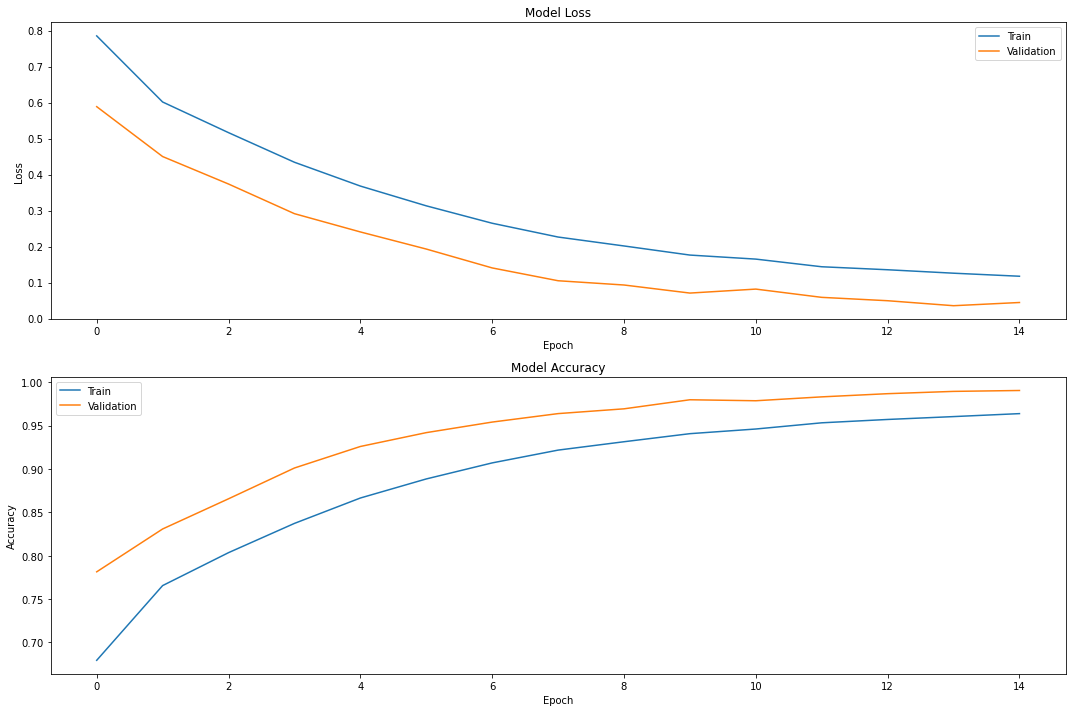

In [118]:
# Plot loss and accuracy
plt.subplots(2,1, figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(2,1,2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [119]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model12.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
print(f"Test Loss: {result[0]:.4f}")
predictions = model12.predict(X_test)

Train Accuracy: 0.9638
Test Accuracy: 0.7359
Test Loss: 1.5543


# Model 3.7 - running 3.4 at longer epochs
<a id='3.7'></a>

In [120]:
# Create a new sequential model
model13 = keras.Sequential()

# Declare the hidden layers
model13.add(layers.Dense(250, activation="relu"))
model13.add(Dropout(0.4))
model13.add(layers.Dense(500, activation="relu"))
model13.add(layers.Dense(250, activation="relu"))
model13.add(Dropout(0.4))
model13.add(layers.Dense(500, activation="relu"))
model13.add(layers.Dense(250, activation="relu"))
model13.add(Dropout(0.4))
model13.add(layers.Dense(500, activation="relu"))


# Declare the output layer
model13.add(layers.Dense(4, activation="softmax"))

In [121]:
# Set optimizer, loss, and metrics for our neural network
model13.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [122]:
# Fit model on our train data
history = model13.fit(X_remainder,y_remainder, validation_data = (X_validation,y_validation), epochs=30, verbose=1)

Epoch 1/30
1361/1361 [==============================] - 15s 11ms/step - loss: 0.7440 - sparse_categorical_accuracy: 0.6973 - val_loss: 0.5661 - val_sparse_categorical_accuracy: 0.7942
Epoch 2/30
1361/1361 [==============================] - 14s 10ms/step - loss: 0.5708 - sparse_categorical_accuracy: 0.7779 - val_loss: 0.4440 - val_sparse_categorical_accuracy: 0.8348
Epoch 3/30
1361/1361 [==============================] - 13s 10ms/step - loss: 0.4746 - sparse_categorical_accuracy: 0.8167 - val_loss: 0.3429 - val_sparse_categorical_accuracy: 0.8841
Epoch 4/30
1361/1361 [==============================] - 13s 9ms/step - loss: 0.3860 - sparse_categorical_accuracy: 0.8532 - val_loss: 0.2507 - val_sparse_categorical_accuracy: 0.9156
Epoch 5/30
1361/1361 [==============================] - 13s 9ms/step - loss: 0.3108 - sparse_categorical_accuracy: 0.8848 - val_loss: 0.1850 - val_sparse_categorical_accuracy: 0.9446
Epoch 6/30
1361/1361 [==============================] - 13s 9ms/step - loss: 0.253

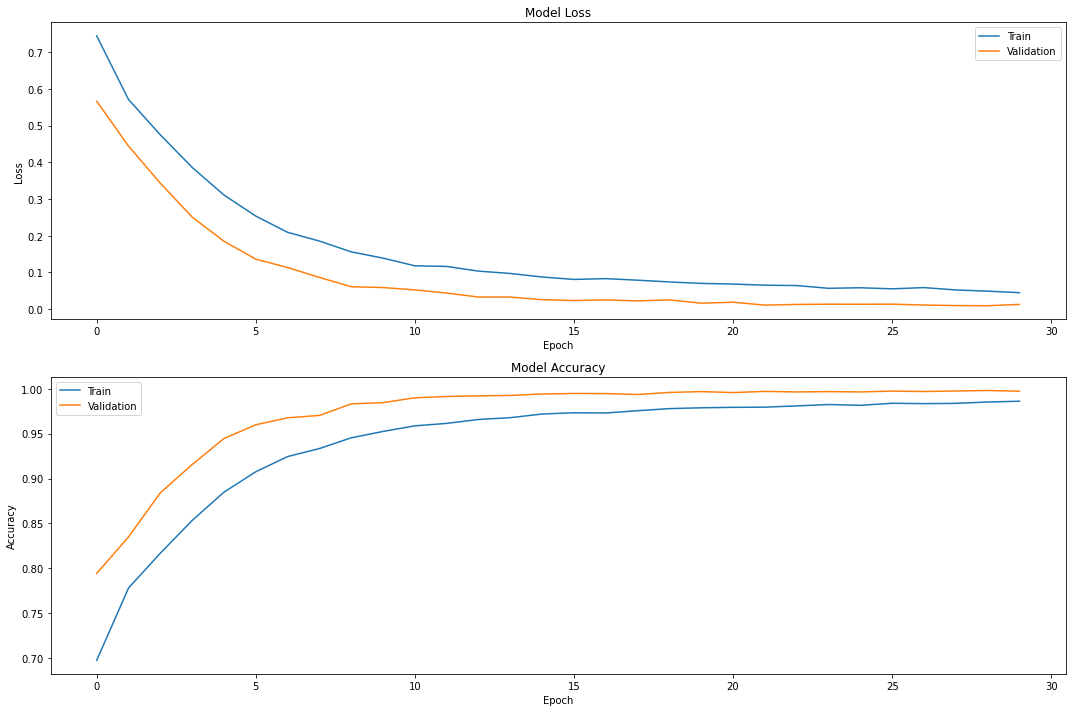

In [123]:
# Plot loss and accuracy
plt.subplots(2,1, figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(2,1,2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [124]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model13.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
print(f'Test Loss: {result[0]:.4f}')

predictions = model13.predict(X_test)

Train Accuracy: 0.9862
Test Accuracy: 0.7335
Test Loss: 1.9077


**Model Assessment with Neural Networks** <br>
    
| Model   | Test Accuracy   | Test Loss |
|-------------|-------|-------|
| [Model 1.0](#1) | 0.6972 | 7.0434 |
| [Model 1.1](#1.1) | 0.7025 | 2.8806 |
| [Model 2.0](#2.0) | 0.7067 | 4.3566 |
| [Model 2.1](#2.1) | 0.7139 | 2.7307 |
| [Model 2.2](#2.2) | 0.7229 | 2.3376 |
| [Model 2.3](#2.3) | 0.7326 | 1.6859 |
| [Model 3.0](#3.0) | 0.7178 | 3.7912 |
| [Model 3.1](#3.1) | 0.7159 | 3.2407 |
| [Model 3.2](#3.2) | 0.7215 | 2.4860 |
| [Model 3.3](#3.3) | 0.7303 | 2.1344 |
| [Model 3.4](#3.4) | 0.7219 | 3.2631 |
| [Model 3.5](#3.5) | 0.7381 | 1.6143 |
| [Model 3.6](#3.6) | 0.7359 | 1.5543 |
| [Model 3.7](#3.7) | 0.7335 | 1.9077 |


The test accuracies of each model can be seen in the table above. The loss values were not included as each model had a loss of less than ~0.10. It seems that Model 3.5 had the best test accuracy, so therefore I will create a confusion matrix based on that, as well as observe precision and recall values. Due to time constraints, I have chosen to just check Model 3.5, however ideally, the next steps for this model would be to check the recall and precision for every model.

# Model 3.5 Precision and Recall
<a id='PR'></a>

In order to check the precision and recall values of model 3.5, we need to calculate the predictions, and then convert the probabilities to specific cuisine labels.

In [135]:
# Calculate the predictions
predict_probas = model11.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

In [136]:
# TEST
print("TEST SET")
print(classification_report(y_test, y_predict))

TEST SET
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      4499
           1       0.75      0.72      0.73      3690
           2       0.84      0.82      0.83      1925
           3       0.54      0.56      0.55       770

    accuracy                           0.73     10884
   macro avg       0.71      0.71      0.71     10884
weighted avg       0.74      0.73      0.74     10884



The precision and recall values of our model is listed above. Judging from the recall values, it seems model 3.5 does well classifying majority of the european, asian, and american cuisines, however it struggles to classify mexican. Let's look at a confusion matrix to visualize what the model is struggling with.

In [137]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test,y_predict)

# Normalize confusion matrix
normalized_conf_mat = conf_matrix/conf_matrix.astype(np.float).sum(axis=1, keepdims=True)
normalized_conf_mat

array([[0.73794176, 0.1542565 , 0.03511892, 0.07268282],
       [0.24065041, 0.72059621, 0.03197832, 0.00677507],
       [0.08155844, 0.08207792, 0.82441558, 0.01194805],
       [0.36883117, 0.04805195, 0.02207792, 0.56103896]])

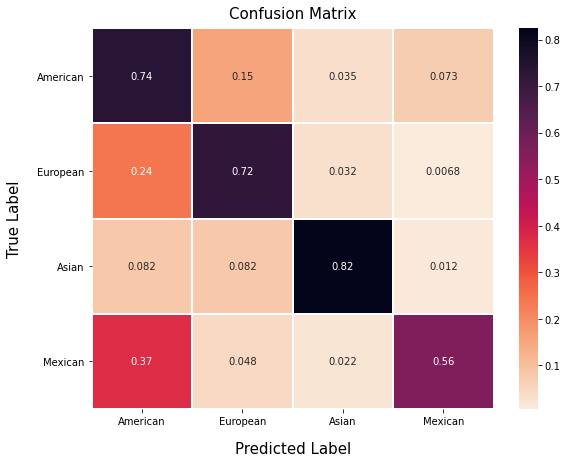

In [138]:
# Plot confusion matrix
plt.figure(figsize = (9,7))

sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=True,
            cmap="rocket_r",
            linewidths=1
           )
plt.xlabel("Predicted Label", size = 15, labelpad = 15)
plt.ylabel("True Label", size = 15, labelpad = 15)
plt.title('Confusion Matrix',size =15,y = 1.01)
plt.xticks(ticks = np.arange(4)+0.5, labels = ['American','European','Asian','Mexican'])
plt.yticks(ticks = np.arange(4)+0.5, labels = ['American','European','Asian','Mexican'],rotation = 0)
plt.show()

It looks like overall, the model struggles when classifying american cuisine and european cuisine, as well as mexican and american cuisines. The confusion matrix we conducted on our logistic regression performed slightly better, and therefore I will go ahead and use my optimized logistic regression model as my "final model".